<a href="https://colab.research.google.com/github/Moimschoh/data-analyst/blob/main/plot_PassCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


# Statistical modelling

In this section we look at a variety of methods for both evaluating
the degree to which passing/possession lead to more goals being scroed and
how we can identify the strongest areas on the pitch for a team.


In [ ]:
#importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Sbopen, Pitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colors

#open data from WWC 2019
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)

## Preparing data
For our task we need 2 different dataframes. The first one called *passshot_df*. In this dataframe we would like to keep information
about team performance in every game they played - index of a game, name of a team, number of shots, number of goals and number
of danger passes by this team.
Moreover, we need the dataframe of all danger passes during the tournament - *danger_passes_df*.



In [ ]:
#get names of all teams
teams = df_match["home_team_name"].unique()
#get indicies of all games
match_ids = df_match["match_id"]

#empty dataframes
passshot_df = pd.DataFrame()
danger_passes_df = pd.DataFrame()
#for every game in the tournament
for idx in match_ids:
    #open event data
    df = parser.event(idx)[0]
    #get home and away team
    home_team = df_match.loc[df_match["match_id"] == idx]["home_team_name"].iloc[0]
    away_team = df_match.loc[df_match["match_id"] == idx]["away_team_name"].iloc[0]
    #for both teams
    for team in [home_team, away_team]:
        #declare variables to sum shots, passes and danger passes from both halves
        shots = 0
        passes = 0
        danger_passes = 0
        #for both periods - see previous lessons
        for period in [1, 2]:
            #passes
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            pass_df = df.loc[mask_pass]
            #A dataframe of shots
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            #Find passes within 15 seconds of a shot, exclude corners.
            shot_df = df.loc[mask_shot, ["minute", "second"]]
            #convert time to seconds
            shot_times = shot_df['minute']*60+shot_df['second']
            shot_window = 15
            #find starts of the window
            shot_start = shot_times - shot_window
            #condition to avoid negative shot starts
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
            #convert to seconds
            pass_times = pass_df['minute']*60+pass_df['second']
            #check if pass is in any of the windows for this half
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
            danger_passes_period = pass_df.loc[pass_to_shot]

            #will need later all danger passes
            danger_passes_df = pd.concat([danger_passes_df, danger_passes_period], ignore_index = True)

            #adding number of passes, shots and danger passes from a game
            passes += len(pass_df)
            shots += len(shot_df)
            danger_passes += len(danger_passes_period)
        #getting number of goals by the team from the game
        if team == home_team:
            goals = df_match.loc[df_match["match_id"] == idx]["home_score"].iloc[0]
        else:
            goals = df_match.loc[df_match["match_id"] == idx]["away_score"].iloc[0]
        #appending passshot dataframe
        match_info_df = pd.DataFrame({
                    "Team": [team],
                    "Passes": [passes],
                    "Shots": [shots],
                    "Goals": [goals],
                    "Danger Passes": [danger_passes]
                    })
        passshot_df = pd.concat([passshot_df, match_info_df])

## Plotting data
We would like to investigate if there is any relation between number of passes and number of shots by a team in a game.
First we scatter the data. We also want to highlight England Women's team performance in these 2 areas.



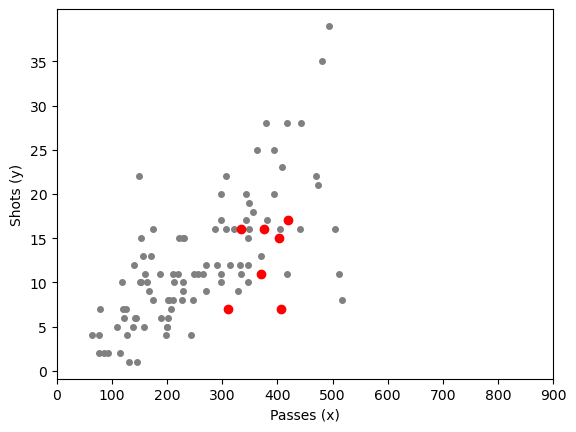

In [ ]:
fig, ax = plt.subplots()
#plot all games
ax.plot('Passes','Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')
#choose only England games and plot them red
england_df  = passshot_df.loc[passshot_df["Team"] == "England Women's"]
ax.plot('Passes','Shots', data=england_df, linestyle='none', markersize=6, marker='o', color='red')
#make legend
ax.set_xticks(np.arange(0,1000,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')
plt.show()

## Fitting linear regression
We want to investigate the linear relationship between number of passes and number of shots. To do so, we fit the
linear regression using statsmodels library. We print out the summary of our model to make conclusions and plot the line
on the previously plotted observations



                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     88.98
Date:                Wed, 21 Aug 2024   Prob (F-statistic):           1.46e-15
Time:                        12:28:34   Log-Likelihood:                -318.20
No. Observations:                 104   AIC:                             640.4
Df Residuals:                     102   BIC:                             645.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3098      1.268      1.033      0.3

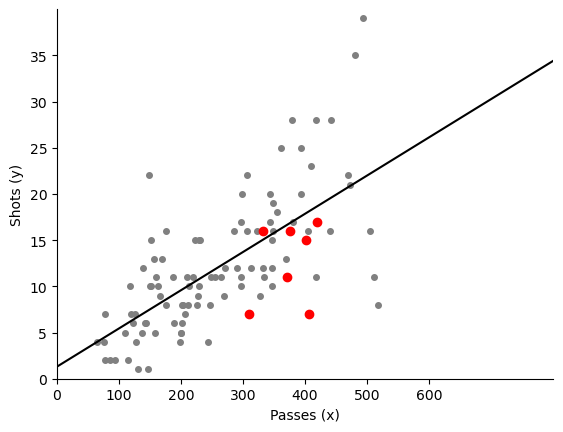

In [ ]:
#repeat plotting points for
fig,ax=plt.subplots()
#plot all games
ax.plot('Passes','Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')
#choose only England games and plot them red
england_df  = passshot_df.loc[passshot_df["Team"] == "England Women's"]
ax.plot('Passes','Shots', data=england_df, linestyle='none', markersize=6, marker='o', color='red')
#make legend
ax.set_xticks(np.arange(0,700,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')

#changing datatype for smf
passshot_df['Shots']= pd.to_numeric(passshot_df['Shots'])
passshot_df['Passes']= pd.to_numeric(passshot_df['Passes'])
passshot_df['Goals']= pd.to_numeric(passshot_df['Goals'])

#fit the model
model_fit=smf.ols(formula='Shots ~ Passes', data=passshot_df[['Shots','Passes']]).fit()
#print summary
print(model_fit.summary())
#get coefficients
b = model_fit.params
#plot line
x = np.arange(0, 1000, step=0.5)
y = b[0] + b[1]*x
ax.plot(x, y, linestyle='-', color='black')
#make legend
ax.set_ylim(0,40)
ax.set_xlim(0,800)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Fitting Poisson regression
We want to investigate the  relationship between number of passes and number of goals. To do so, we fit the
Poisson regression using statsmodels library. It is better to use Poisson regression since goals are infrequent.
We print out the summary of our model to make conclusions and plot the line
on the previously plotted observations



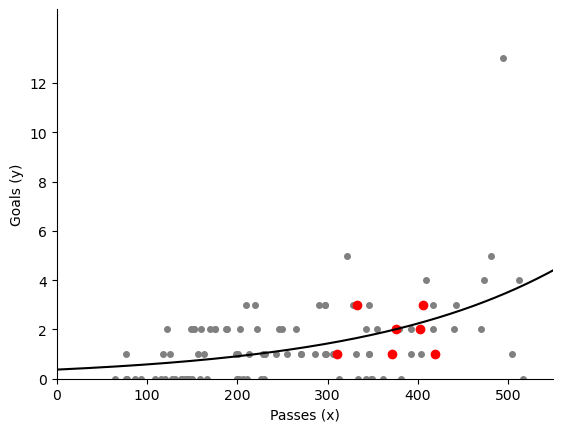

In [ ]:
fig,ax=plt.subplots()
#plot all games
ax.plot('Passes','Goals', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')
#choose only England games and plot them red
england_df  = passshot_df.loc[passshot_df["Team"] == "England Women's"]
ax.plot('Passes','Goals', data=england_df, linestyle='none', markersize=6, marker='o', color='red')
#make legend
ax.set_xticks(np.arange(0,700,step=100))
ax.set_yticks(np.arange(0,13,step=2))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Goals (y)')

#fit the model
poisson_model = smf.glm(formula="Goals ~ Passes", data=passshot_df,
                    family=sm.families.Poisson()).fit()
#print summary
poisson_model.summary()
#get coefficients
b = poisson_model.params
#plot line
x = np.arange(0, 1000, step=0.5)
y = np.exp(b[0] + b[1]*x)
ax.plot(x, y, linestyle='-', color='black')
#make legend
ax.set_ylim(0,15)
ax.set_xlim(0,550)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Comparative heatmaps
We would like to find out which team outperformed and underperformed when it comes to the number of danger passes from different zones.
First we draw 24 pitches, one for each team that played in WWC 2019. Then, for each team, we calculate the number of passes in
each bin and normalize it by number of games by this team. As the next step we calculate average number of danger passes per zone
throughout the tournament. For every team, we subtract it from the number of danger passes in each zone. As the last step, we plot
the heat map for each team.



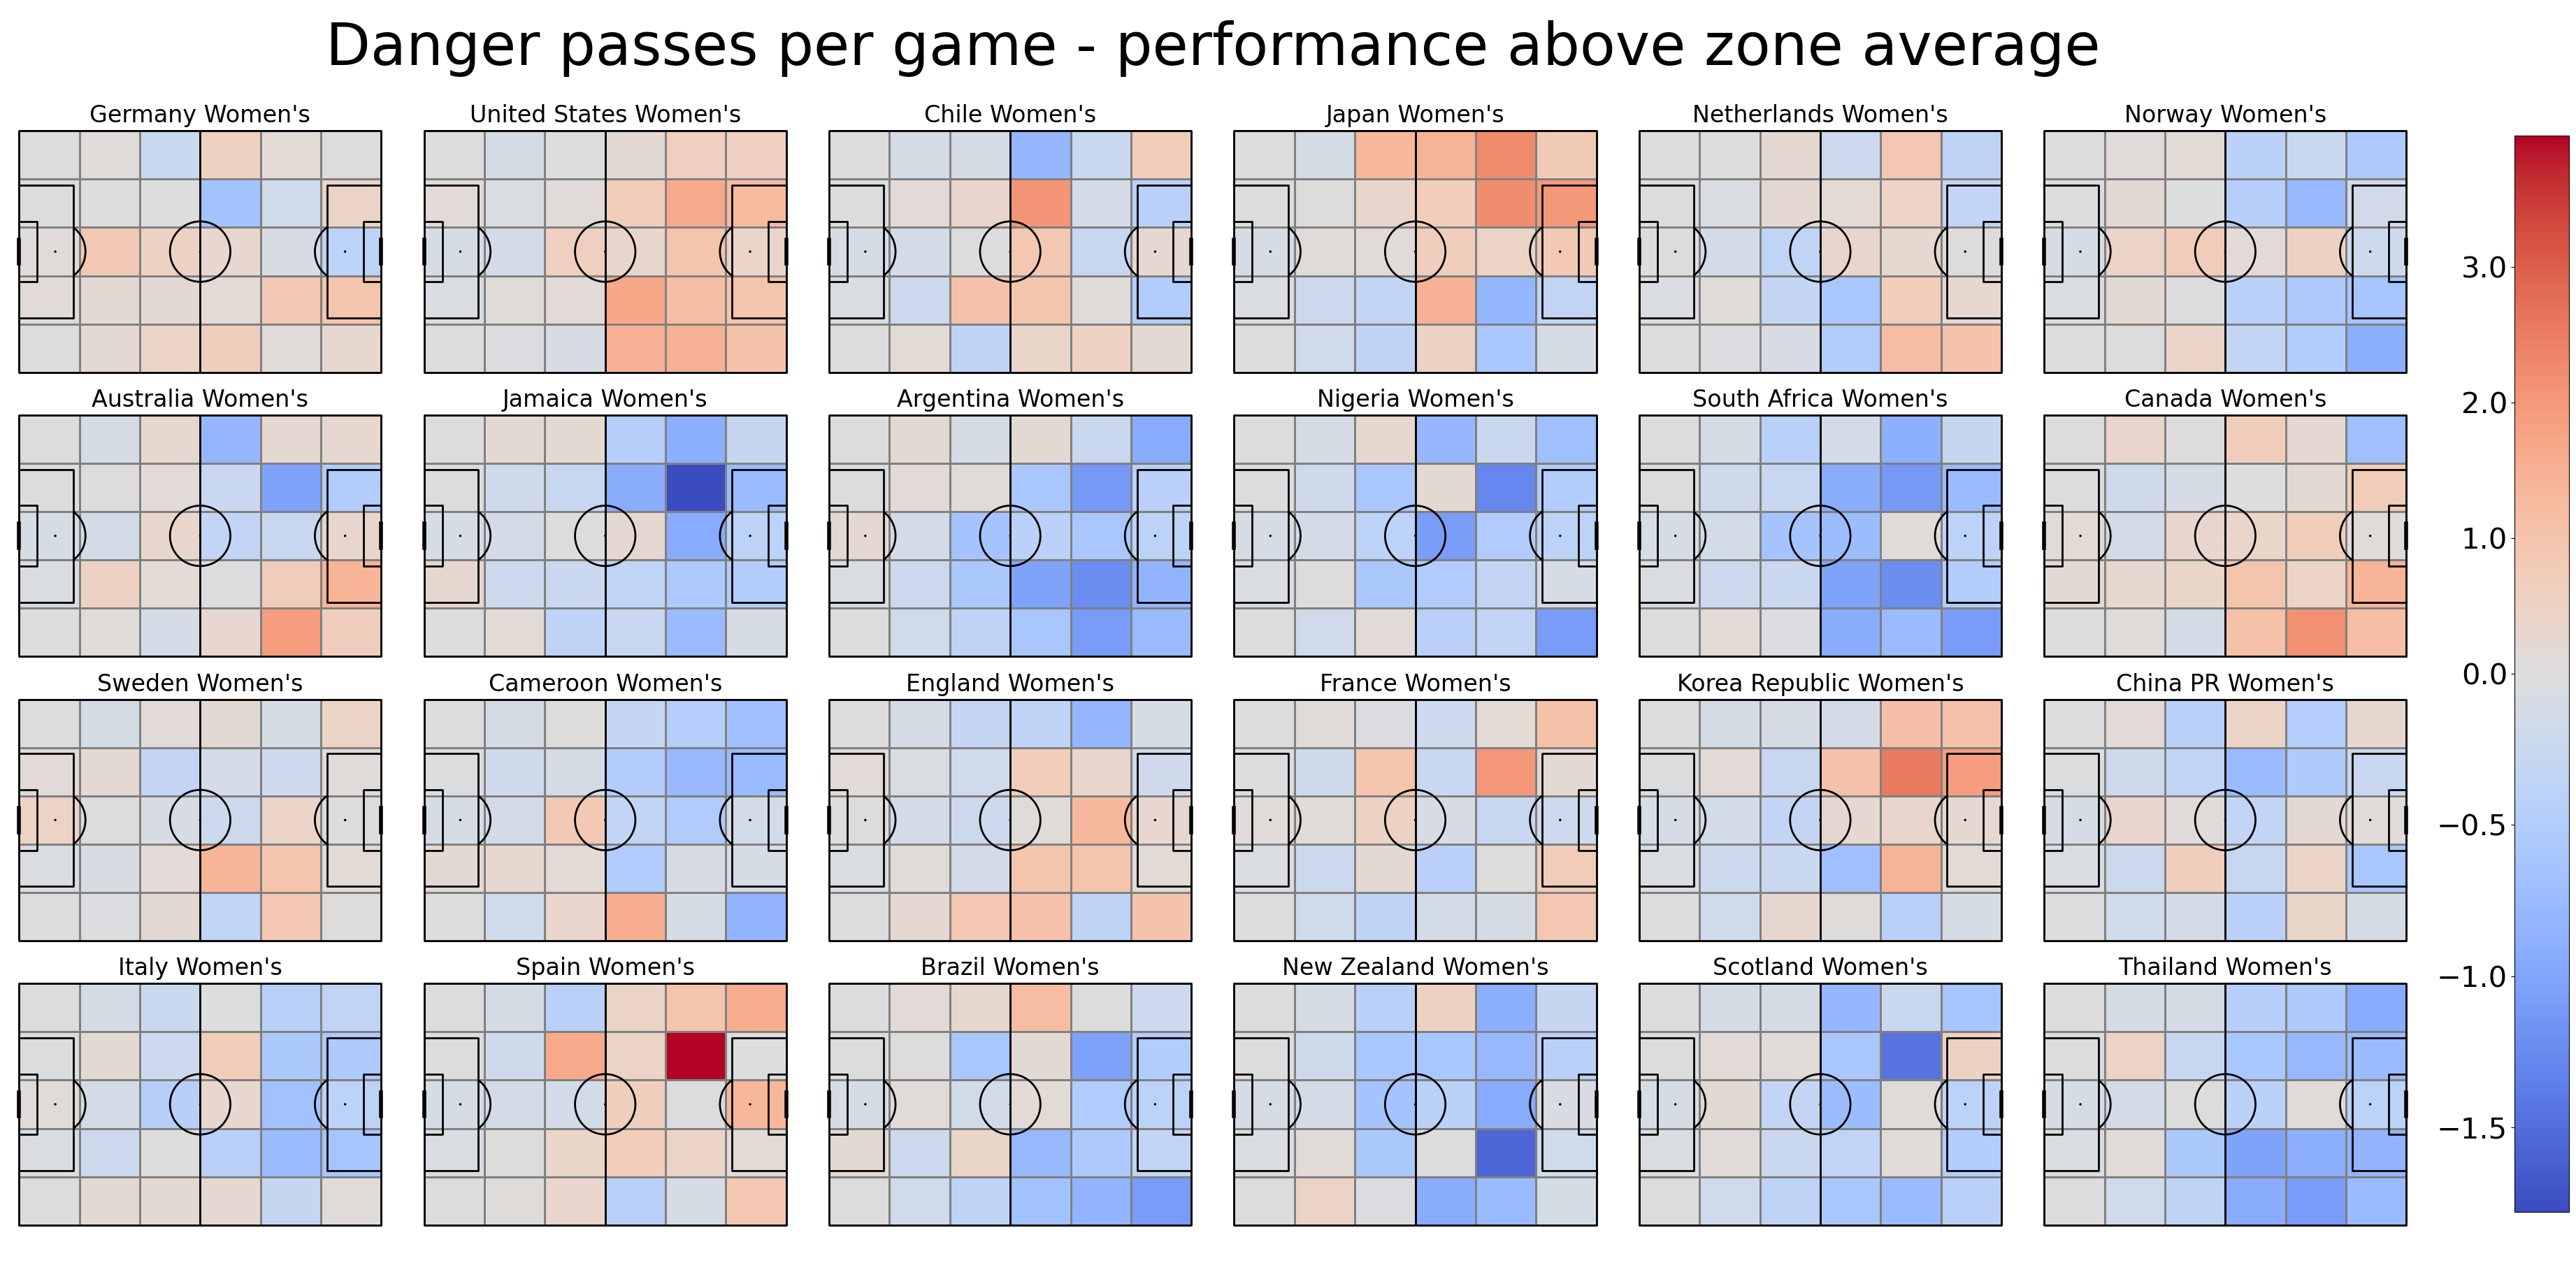

In [ ]:
#plot pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 6, nrows = 4, figheight=20,
                      grid_width=0.88, left=0.025,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=0.8)

#for each team store  bins in a dictionary
hist_dict = {}
for team in teams:
    #get number of games by team
    no_games = len(df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)])
    #get danger passes only by this team
    team_danger_passes = danger_passes_df.loc[danger_passes_df["team_name"] == team]
    #number of danger passes in each zone
    bin_statistic = pitch.bin_statistic(team_danger_passes.x, team_danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
    #normalize by number of games
    bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
    #store in dictionary
    hist_dict[team] = bin_statistic

#calculating average per game per team per zone
avg_hist = np.mean(np.array([v["statistic"] for k,v in hist_dict.items()]), axis=0)

#subtracting average
for team in teams:
    hist_dict[team]["statistic"] = hist_dict[team]["statistic"] - avg_hist

#preparing colormap
vmax = max([np.amax(v["statistic"]) for k,v in hist_dict.items()])
vmin = min([np.amin(v["statistic"]) for k,v in hist_dict.items()])
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#for each player
for team, ax in zip(teams, axs['pitch'].flat):
    #put team name over the plot
    ax.text(60, -5, team,
            ha='center', va='center', fontsize=24)
    #plot colormap
    pcm  = pitch.heatmap(hist_dict[team], ax=ax, cmap='coolwarm', norm = divnorm, edgecolor='grey')

#make legend
ax_cbar = fig.add_axes((0.94, 0.093, 0.02, 0.77))
cbar = plt.colorbar(pcm, cax=ax_cbar, ticks=[-1.5, -1, -0.5, 0, 1, 2, 3])
cbar.ax.tick_params(labelsize=30)
ax_cbar.yaxis.set_ticks_position('left')
#add title
axs['title'].text(0.5, 0.5, 'Danger passes per game - performance above zone average', ha='center', va='center', fontsize=60)
plt.show()

## References
You can find detailed documentation and resources on soccer analytics at the following link:

[Soccermatics Documentation](https://soccermatics.readthedocs.io/en/latest/index.html)